<a href="https://colab.research.google.com/github/suptechlab/Data-Gymnasium/blob/main/notebooks/M2_4_Financial_network_analysis_using_graph_data_structures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Financial network analysis using graph data structures

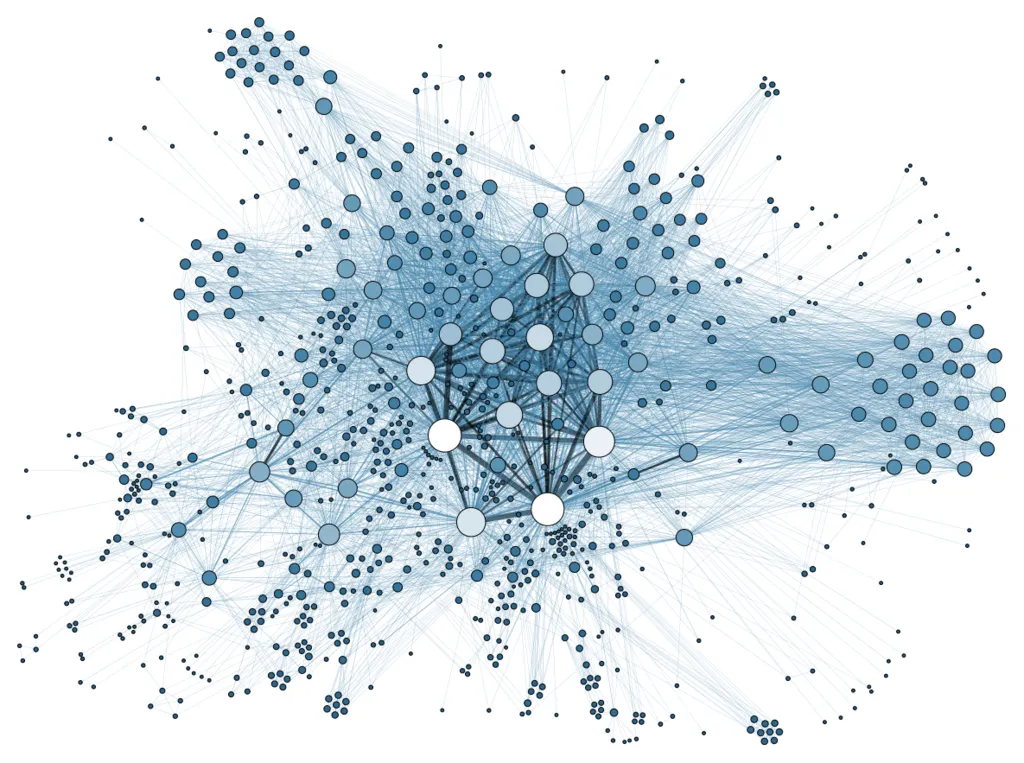

## Disclaimer

-----------------------------------------------------------------------------------------
**This data science notebook is provided for educational purposes only.**

It contains code, analysis, and models that are intended to serve as learning materials and examples. The content is not intended for direct deployment to production environments.

You are encouraged to adapt and modify the contents of this notebook in accordance with the license provided in the associated github repository. However, it is essential to exercise caution, further development, and thorough testing before considering any deployment to production systems.

The authors and contributors of this notebook assume no liability for any consequences, including financial or operational, resulting from the use or misuse of the information and code provided herein. Always consult with appropriate experts and conduct rigorous testing and validation before applying any techniques or models in a real-world, production context.

**By using this notebook, you agree to these terms and conditions.**

-----------------------------------------------------------------------------------------


# Background

## Content

FNA BIS report (network science primer): https://www.bis.org/ifc/publ/ifcb50_10.pdf

Portugal BIS report (primer, evolution from heatmap to network, conclusions): https://www.bis.org/ifc/publ/ifcb52_27.pdf

2015 Bank of England speech (visualizations): https://web.archive.org/web/20150327112210/https://www.bankofengland.co.uk/publications/Documents/speeches/2015/speech812.pdf

Some questions necessitate a new way of looking at data:

* How is data connected with other data?
* How do these connections matter?
* How do complex systems move in time?

Because of graph data structures and network analysis techniques, for the first time we are able to measure and model this!

## Resources and acknowledgements
The tech:
* NetworkX library & tutorial: https://networkx.org/documentation/latest/tutorial.html
* PyVis: https://pyvis.readthedocs.io/en/latest/tutorial.html

The financial context:
* The Political Economy of Global Finance: A Network Model: https://www.researchgate.net/publication/259431599_The_Political_Economy_of_Global_Finance_A_Network_Model#fullTextFileContent
  * Countries: France, finland, denmark, canada, belgium, australia, us, uk, switzerland, spain, netherlands, japan
* Former BIS "Table 9b" (2013): https://www.bis.org/statistics/r_qa1406_hanx9b.pdf
  * Countries: Australia, Austria, Belgium, Brazil, Canada, Chile, Chinese Taipei, Denmark, France, Germany, Ireland, Italy, Japan, Korea, Mexico, Netherlands, Panama, Portugal, Spain, Sweden, Switzerland, Turkey, United Kingdom, United States
* Now called B4: https://www.bis.org/statistics/annex_map.htm

The supervisory context:
* The Structure and Resilience of the European Interbank Market: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3723333
  * Measures of network centrality
    * Connectivity (cloi/exposures & cloo/funding)
    * Proximity (pgrk)
    * Betweenness (bet)
  * Measures of network fragility

Modeling contagion
* Shock transmission: https://cepr.org/voxeu/columns/shock-transmission-through-global-banking-network
* Financial Networks and Contagion: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2175056
* Professor at University of Cambridge: https://sites.google.com/view/matthewlelliott/
  * role of networks in antitrust investigations
  * networks and economic policy

Other supervisory contexts
* For derivatives supervision (HKMA): https://www.hkma.gov.hk/media/eng/publication-and-research/quarterly-bulletin/qb201506/fa.pdf
* Graph pathfinding for FX Liquidity: https://www.linkedin.com/pulse/graph-pathfinding-approach-fx-liquidity-challenges-anthony-butler-gu2he
* Network analytics for social media: https://colab.research.google.com/github/zlisto/social_media_analytics/blob/main/Lecture10_NetworkCentrality.ipynb
* Network analytics for fraud detection in banking and finance: https://www.cylynx.io/blog/network-analytics-for-fraud-detection-in-banking-and-finance/
  * Use cases: Fraud rings, synthetic identities, account takeover, insurance fraud
  * Techniques: centrality measures, paths and traversal, entity link analysis, cluster analysis

Forward looking
* Graph neural nets for financial networks: https://snap.stanford.edu/graphlearning-workshop/slides/stanford_graph_learning_Finance.pdf
* Literature on graph neural nets (GNNs): https://arxiv.org/abs/2011.08843
* Python library for graph neural nets: https://pyg.org/


## Defining our target

In a [VUCA world](https://hbr.org/2014/01/what-vuca-really-means-for-you) where even some of the most prominent institutions can fail, it's important to understand the implications and how this can propogate through the network.

While this is a deep specialization with a plethora of techniques, we will focus initially on several components. If a node is going to fail, we want to know:

* Which are the most important nodes in the network?
* How many others are connected, and how strong are these connections?
* Are there particular groups that are most susceptible?

## Installing and importing libraries

In [12]:
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.3 MB/s eta 0:00:00


In [155]:
##########################################
# General helper functions and libraries #
##########################################

# General plotting libs
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

####################
# Modeling process #
####################

# Networks
import networkx as nx
from pyvis.network import Network

# Data

## Getting the data

Here we take a slightly different approach than some of the other notebooks in the Data Gymnasium.

First off, most of the data available for network analytics have more to do with [websites, collaborations, utility networks](http://networksciencebook.com/translations/en/resources/data.html), [social, political](http://web.stanford.edu/~jacksonm/Data.html) data or otherwise. While the simple examples can be super helfpul for learning the ropes, we want something that relates to the financial sector, and ideally pertains to supervision. Notably that second link contains a dataset for modeling contagion, but it is relatively too advanced for an introductory course.

Because there's not a whole lot of org-level network data out there, and even fewer that are availble in graph database format, we'll start with a tabular dataset published by the BIS, then convert to the graph data from there.

The rationale for converting to graph data is to afford us the ability to use standardized metrics there to understand the important features of the network.

In [3]:
# Based on: https://www.bis.org/statistics/r_qa1406_hanx9b.pdf
# Originally from "Consolidated Banking Statistics, Updated 27 July 2023" described at: https://www.bis.org/statistics/consstats.htm
# Full set here: https://www.bis.org/statistics/full_data_sets.htm
# Retrieved on 13 Oct

# File, will take ~15sec to load
import pandas as pd
df = pd.DataFrame(pd.read_csv('https://storage.googleapis.com/suptech-lab-practical-data-science-public/WS_CBS_PUB_csv_col.csv'))
df.shape

(174575, 151)

In [4]:
df.columns

Index(['FREQ', 'Frequency', 'L_MEASURE', 'Measure', 'L_REP_CTY',
       'Reporting country', 'CBS_BANK_TYPE', 'CBS bank type', 'CBS_BASIS',
       'CBS reporting basis',
       ...
       '2020-Q4', '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4', '2022-Q1',
       '2022-Q2', '2022-Q3', '2022-Q4', '2023-Q1'],
      dtype='object', length=151)

## Checking and cleaning the data

Great, we have the data loaded in. Now, to match our target, we need:
* Consolidated foreign claims of reporting banks
* Immediate borrower basis
* On individual countries by nationality of reporting banks
* Amounts outstanding
* End December, 2013
* In millions of US dollars

In [5]:
# Immediate borrower basis
set(df['CBS reporting basis'])

{'Guarantor basis',
 'Immediate counterparty basis',
 'Net risk transfers (Inward-Outward)',
 'Outward risk transfers'}

In [6]:
# Amounts outstanding
set(df['Measure'])

{'Amounts outstanding / Stocks'}

In [7]:
set(df['Remaining maturity'])

{'Over 1 year and up to and including 2 years',
 'Over 2 years',
 'Total (all maturities)',
 'Up to and including 1 year'}

In [206]:
# List the columns we want to keep
cols = [
  'Reporting country',
  'Counterparty country',
  '2013-Q4',
  '2014-Q4',
  '2015-Q4',
  '2016-Q4',
  '2017-Q4'
]

# 1. Make a copy of the original dataframe
# 2. Filter only for the rows we want
# 3. Keep only the columns we want
df1 = df.copy(deep=True)
df1 = df1[(df1['CBS bank type']=="Domestic banks")
      & (df1['CBS reporting basis']=="Immediate counterparty basis")
      & (df1['Balance sheet position']=="Total claims")
      & (df1['Remaining maturity']=="Total (all maturities)")]
df1 = df1[cols]

# Drop the rows containing global aggregates
df1 = df1[(df1['Reporting country']!="All reporting countries") & (df1['Counterparty country']!="All reporting countries") &
         (df1['Counterparty country']!='All countries (total)') & (df1['Counterparty country']!='All countries excluding residents')]

# Only those who have recorded financial data for the quarter we're looking at
df1 = df1[pd.notnull(df1['2013-Q4'])]

#df1[(df1['Reporting country']=="Sweden") & (df1['Counterparty country']=="Italy")]
#df1[(df1['Reporting country']=="Sweden")]
df1


,Reporting country,Counterparty country,2013-Q4,2014-Q4,2015-Q4,2016-Q4,2017-Q4
113,Australia,Chad,0.008,0.741,0.301,NaN,NaN
172,Switzerland,Chad,2.028,18.635,0.212,0.021,0.013
234,France,Chad,383.000,662.000,525.000,465.000,491.000
424,United States,Chad,35.000,46.000,44.000,38.000,39.000
513,Austria,Germany,39068.469,37377.994,37690.878,35869.525,42703.591
...,...,...,...,...,...,...,...
174270,Denmark,Djibouti,1.000,1.000,1.000,1.000,1.000
174303,France,Djibouti,30.000,58.000,10.000,14.000,12.000
174335,United Kingdom,Djibouti,21.000,17.000,12.000,6.000,NaN
174490,Sweden,Djibouti,18.168,15.395,7.716,1.542,0.351


In [207]:
set(df1['Reporting country'])

{'Australia',
 'Austria',
 'Belgium',
 'Brazil',
 'Canada',
 'Chile',
 'Chinese Taipei',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Ireland',
 'Italy',
 'Japan',
 'Korea',
 'Mexico',
 'Netherlands',
 'Panama',
 'Portugal',
 'Spain',
 'Sweden',
 'Switzerland',
 'Türkiye',
 'United Kingdom',
 'United States'}

## Preprocessing the data

[WITH SCAFFOLDING IN PLACE, WHAT DO WE NEED TO DO TO THE ACTUAL DATA TO GET IT READY FOR MODELS]



### Putting into a Graph object

Doc: https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html#networkx.convert_matrix.from_pandas_edgelist

In [208]:
# Add nodes
G = nx.from_pandas_edgelist(df1, 'Reporting country', 'Counterparty country', edge_attr=True, create_using=nx.DiGraph)
print("Nodes:", len(G.nodes()), "Edges:", len(G.edges()))

Nodes: 218 Edges: 2733


In [209]:
G['Spain']['Sweden']

{'2013-Q4': 2860.0,
 '2014-Q4': nan,
 '2015-Q4': nan,
 '2016-Q4': nan,
 '2017-Q4': 5846.555}

### Network filtering

Often networks are large and complex and we want to filter out
noise. Filtering techniques give solutions.

Here we filter down to the countries covered in the BIS's historical 9B table, which we'll use for visualizations later on.

In [212]:
short_countries = ['Australia',
                'Austria',
                'Belgium',
                'Brazil',
                'Canada',
                'Chile',
                'Chinese Taipei',
                'Denmark',
                'France',
                'Germany',
                'Ireland',
                'Italy',
                'Japan',
                'Korea',
                'Mexico',
                'Netherlands',
                'Panama',
                'Portugal',
                'Spain',
                'Sweden',
                'Switzerland',
                'Turkey',
                'United Kingdom',
                'United States']
df2 = df1[(df1['Reporting country'].isin(short_countries)) & (df1['Counterparty country'].isin(short_countries)) & (df1['Reporting country'] != df1['Counterparty country'])]
G2 = nx.from_pandas_edgelist(df2, 'Reporting country', 'Counterparty country', edge_attr=True, create_using=nx.DiGraph)

# Analysis

Now that everything is loaded into a network, we can begin to answer such questions as:

* What is the overall structure of the network?
* Who are the important people, or hubs, in the network?
* What are the subgroups and communities in the network?


## Descriptive analysis

### Connected components

In [222]:
list(nx.connected_components(G.to_undirected()))

[{'Afghanistan',
  'Albania',
  'Algeria',
  'Andorra',
  'Angola',
  'Argentina',
  'Armenia',
  'Aruba',
  'Australia',
  'Austria',
  'Azerbaijan',
  'Bahamas',
  'Bahrain',
  'Bangladesh',
  'Barbados',
  'Belarus',
  'Belgium',
  'Belize',
  'Benin',
  'Bermuda',
  'Bhutan',
  'Bolivia',
  'Bonaire, Sint Eustatius and Saba',
  'Bosnia and Herzegovina',
  'Botswana',
  'Brazil',
  'Brunei',
  'Bulgaria',
  'Burkina Faso',
  'Burundi',
  'Cambodia',
  'Cameroon',
  'Canada',
  'Cape Verde',
  'Cayman Islands',
  'Central African Republic',
  'Chad',
  'Chile',
  'China',
  'Chinese Taipei',
  'Colombia',
  'Comoros',
  'Congo',
  'Congo Democratic Republic',
  'Costa Rica',
  "Cote d'Ivoire",
  'Croatia',
  'Cuba',
  'Curacao',
  'Cyprus',
  'Czechia',
  'Denmark',
  'Djibouti',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'Egypt',
  'El Salvador',
  'Equatorial Guinea',
  'Eritrea',
  'Estonia',
  'Eswatini',
  'Ethiopia',
  'Euro area',
  'Faeroe Islands',
  'Falkland Isla

### Degree

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd78df33400>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd78df316c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fd78df31660>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd78df33dc0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd78df31f30>],
 'means': []}

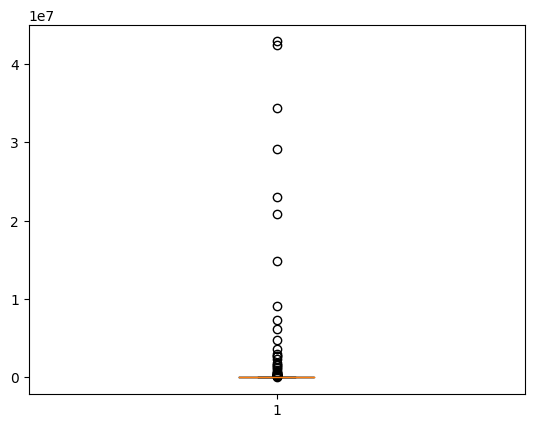

In [217]:
degree_values = [v for k, v in G.degree(weight='2013-Q4')]
fig = plt.figure();
plt.boxplot(degree_values)

## Centrality

There are a variety of network centrality functions we can use in networkx.  We will use several here.  

1. **In-degree centrality** measures how many incoming connections or links are directed towards a node in a directed network.
2. **Out-degree centrality** measures how many outgoing connections or links originate from a node in a directed network.
3. A Node with highest **betweenness centrality** is one that
participates as an “intermediary” in many paths.
4. A Node with the highest **closeness centrality** is the one
that is closer in average to all other nodes in the network
5. **Eigenvector centrality** can be thought of as follows: a node is influential if it's connected with influential nodes. (note that this works best with fully-connected networks; for other networks, Katz centrality can be used)

In code:

1. `Din` = In-degree centrality (networkx divides the in-degree by `nv`-1 so the maximum value =1)

2. `Dout` = Out-degree (networkx divides the out-degree by `nv`-1 so the maximum value =1)

3. `CC` = Closeness centrality (we need to reverse edges of `G` to match networkx convention using the `reverse()` function)

4. `BC` = Betweenness centrality (making the network undirected makes this work better)

5. `EC` = Eigenvector centrality (we need to reverse edges of `G` to match networkx convention  using the `reverse()` function)

We need to be careful with closeness and eigenvector centrality, as their definition of an edge is the reverse of our convention for social networks.

In [218]:
Din = nx.in_degree_centrality(G)
Dout = nx.out_degree_centrality(G)
CC = nx.closeness_centrality(G.reverse())  #reverse edges to match networx convention
BC = nx.betweenness_centrality(G.to_undirected())
EC = nx.eigenvector_centrality(G.reverse())  #reverse edges to match networx convention

### Convert centralities into a dataframe

The centralities calculated by networkx are returned as a *dictionary*.  A dictionary stores data as (key,value) pairs.  To access a value for a key **key** from a dictionary **Dic** you write:  `value = Dic[key]`.

We will convert the dictionaries into lists.  We do this using a `for` loop that goes through every single key (which is a screen name) in the dictionaries, gets the corresponding centrality values, and creates a dictionary of the centralties for this screen name.  Then we append this dictionary to a list called `dictionary_list`.  Then we convert this list of dictionaries into a dataframe with the `DataFrame` command.  The resulting centralties dataframe is called `df_centrality`.



In [219]:
#For plotting, we combine all the centrality dictionaries into a dataframe
dictionary_list = []
for country in Din.keys():
    row = {'country':country,
          'in_degree_centrality':Din[country],
          'out_degree_centrality':Dout[country],
          'closeness_centrality':CC[country],
          'betweenness_centrality':BC[country],
          'eigenvector_centrality':EC[country]}
    dictionary_list.append(row)
df_centrality = pd.DataFrame(dictionary_list)

df_centrality.sort_values(by = ['out_degree_centrality'],ascending = False).head()


,country,in_degree_centrality,out_degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality
2,Switzerland,0.115207,0.949309,0.947598,0.155490,0.218025
3,France,0.119816,0.889401,0.896694,0.112639,0.218025
13,United Kingdom,0.115207,0.852535,0.871486,0.098012,0.208945
0,Australia,0.105991,0.815668,0.844358,0.110300,0.208945
4,United States,0.119816,0.815668,0.841085,0.085049,0.218025


### Plot top centralities

We will sort the top centralities descending order.  To make one big figure we use the subplot function.

To make our code more efficient, we create a list `Centrality` that contains the name of each column of `df_centrality` that corresponds to a centrality.  Then we run a `for` loop over the centralties in this list, and make a bar plot of the top `kmax` values.  We make subplots for each centrality in one big figure.  There are many plot commands used here to make the figure look nice.  Have a look at them to see what they do.

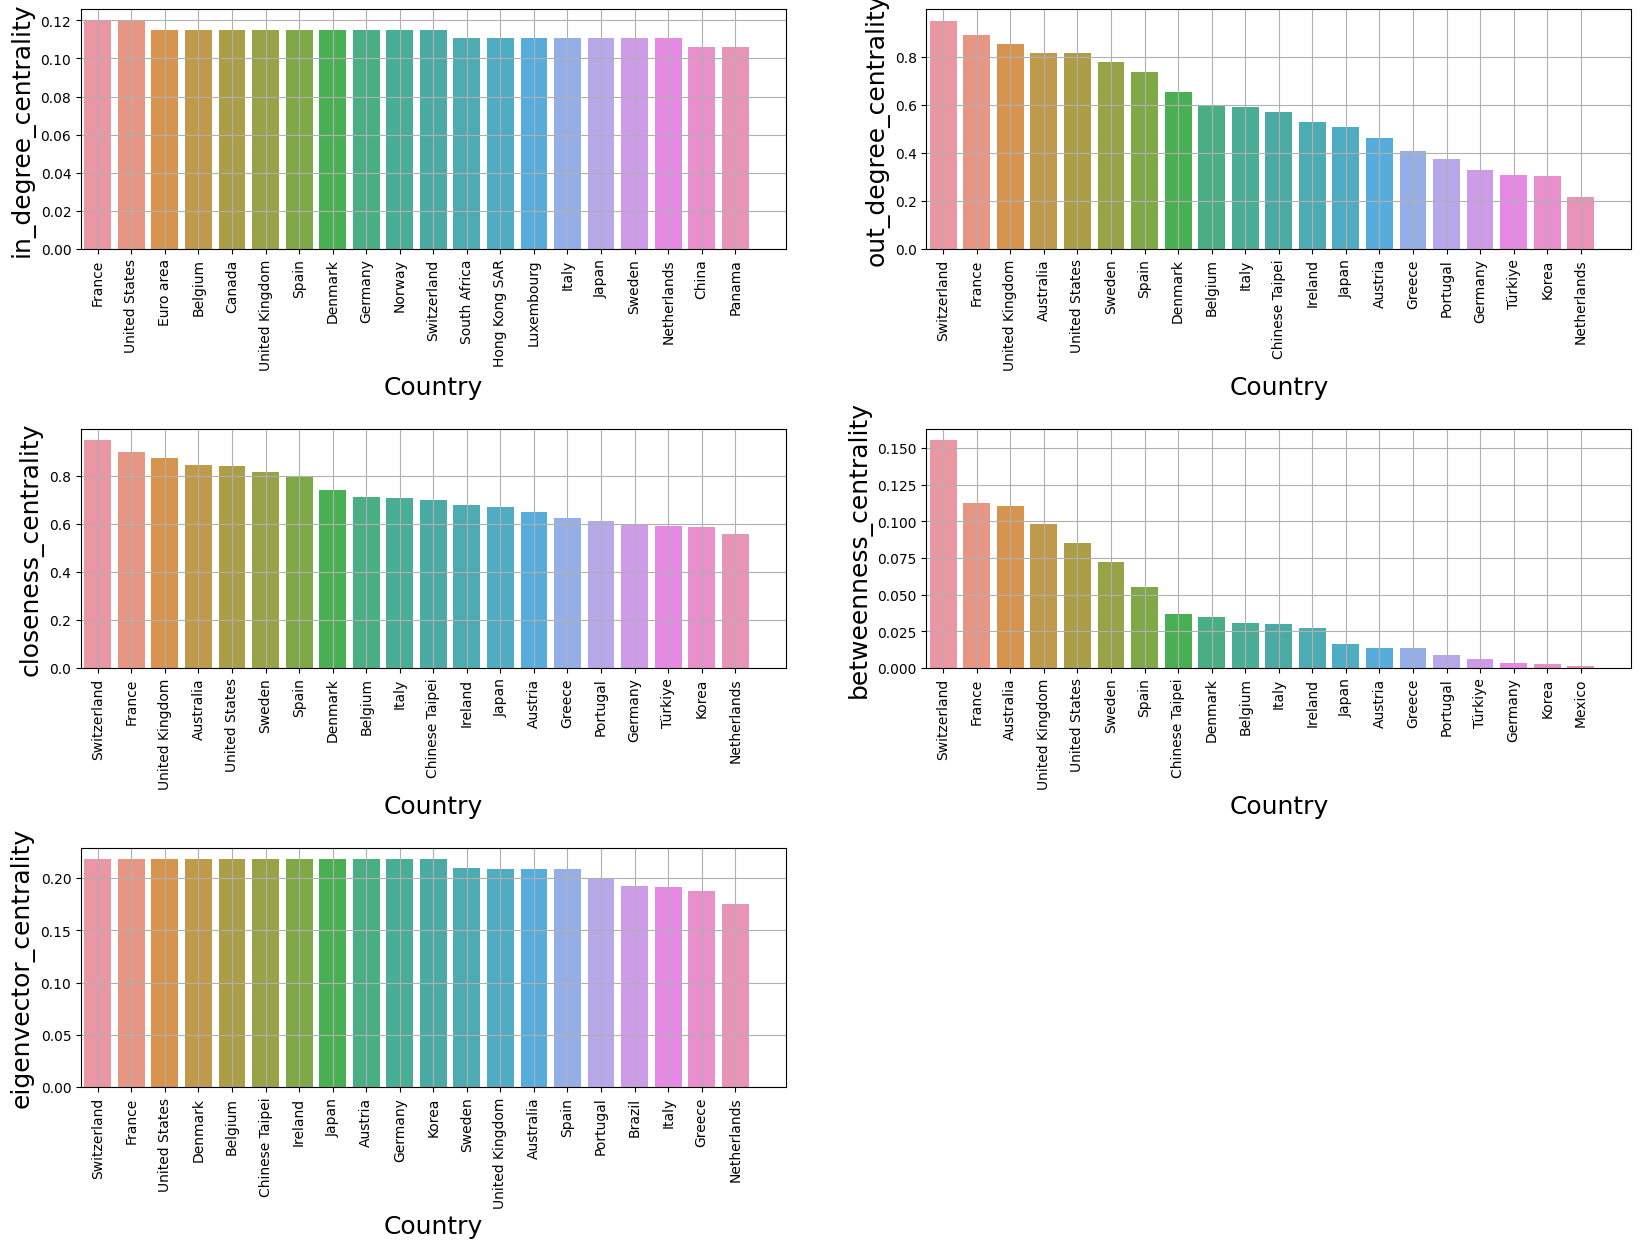

In [220]:
Centrality_names = df_centrality.columns.tolist()[1:]
kmax = 20  #show top kmax users


fig = plt.figure(figsize = (20,14))

for count,centrality_name in enumerate(Centrality_names):
    plt.subplot(3,2,count+1) #make a 2 x 3 subplot, plot in box cnt+1
    df_plot = df_centrality.sort_values(by=[centrality_name],ascending=False).head(n=kmax)  #sort dataframe by centrality value

    ax = sns.barplot(data=df_plot, x='country', y=centrality_name)
    plt.xlim([-.5,kmax+.5])  #set xlimits to only show top kmax users
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)  #rotate axis tick labels 90 degrees
    #plt.xticks(fontsize = 14)
    #plt.yticks(fontsize = 14)
    plt.ylabel(f"{centrality_name}",fontsize = 18)
    plt.xlabel('Country',fontsize = 18)
    plt.grid()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.75)

plt.show()

## Community detection

Often networks are large and complex and we want to simplify,
categorize and label nodes into meaningful groups.

Community detection is an algorithmic way of doing this, and
there are numerous methods available.

## Shortest path



## Visualizing the data

A few options:
* For small and non-complex (fewer connections) graphs, use inbuilt NetworkX plotting module
* For larger graphs, we can use PyVis as it supports auto-layout (forcing the nodes to be as apart as possible) and provides manual interactions (zoom, drag, select, etc)
* in extreme cases where we want to further play with the network by analyzing the change in network w.r.t. nodes and edges properties, we can use visdcc to plot network in Dash and connect the features to graph with callbacks

[Read more](https://towardsdatascience.com/visualizing-networks-in-python-d70f4cbeb259)

In [215]:
deg = dict(G2.degree(weight='2013-Q4'))
deg = {k: v for k, v in sorted(deg.items(), key=lambda item: item[1], reverse=False)}
deg

{'Panama': 91837.35500000001,
 'Chile': 123038.378,
 'Portugal': 205304.2,
 'Chinese Taipei': 262363.63899999997,
 'Austria': 287373.577,
 'Korea': 312919.34,
 'Mexico': 371630.92,
 'Belgium': 475299.75800000003,
 'Brazil': 476808.78799999994,
 'Denmark': 477052.009,
 'Ireland': 535538.418,
 'Sweden': 734960.921,
 'Australia': 758839.6059999999,
 'Italy': 1136042.052,
 'Canada': 1229541.3969999999,
 'Netherlands': 1589852.076,
 'Switzerland': 1725043.1219999995,
 'Spain': 1798620.346,
 'Japan': 2985436.211,
 'Germany': 3319910.6059999997,
 'France': 3338390.685,
 'United Kingdom': 5074479.721,
 'United States': 7469137.535}

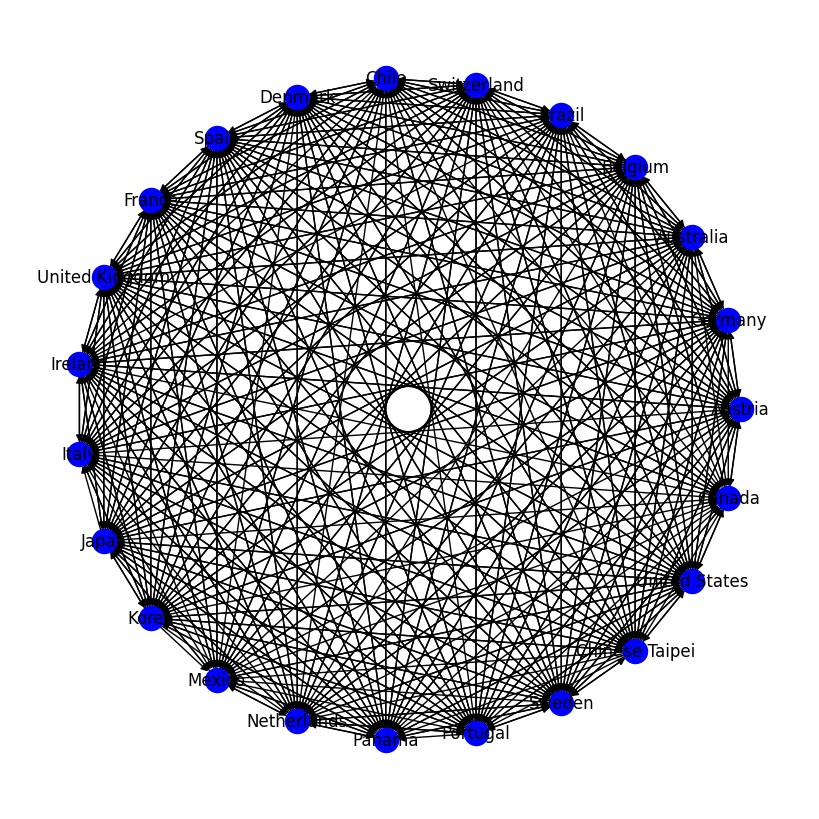

In [214]:
#Draw the network, with labels
node_color = 'blue'
edge_color = 'black'
background_color = 'white'
edge_width = 1

pos = nx.kamada_kawai_layout(G2.to_undirected())

fig = plt.figure(figsize=(8,8))
nx.draw(G2, pos, node_color = node_color, width= edge_width,
        edge_color=edge_color,
       with_labels=True,font_color = 'black')
fig.set_facecolor(background_color)
plt.show()

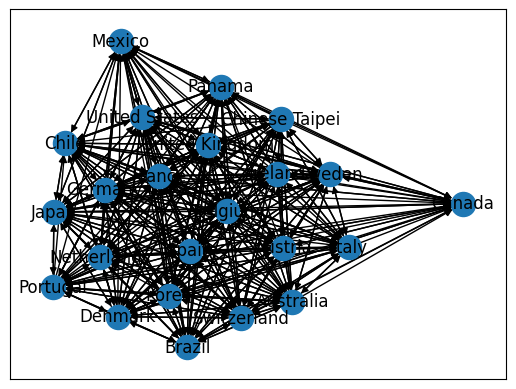

In [213]:
nx.draw_networkx(G2)

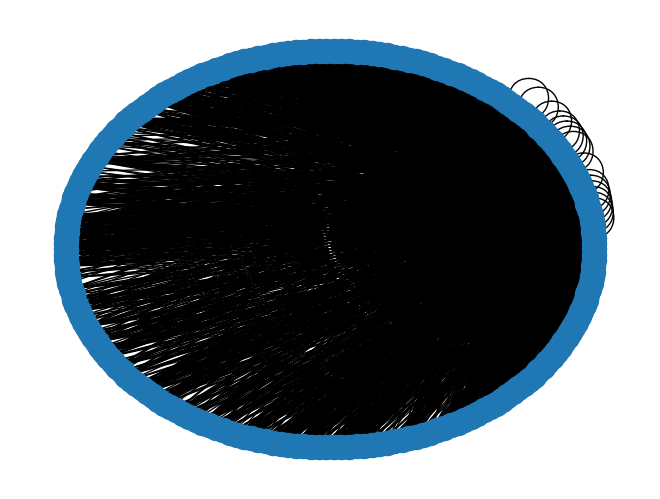

In [211]:
nx.draw_circular(G.to_undirected())

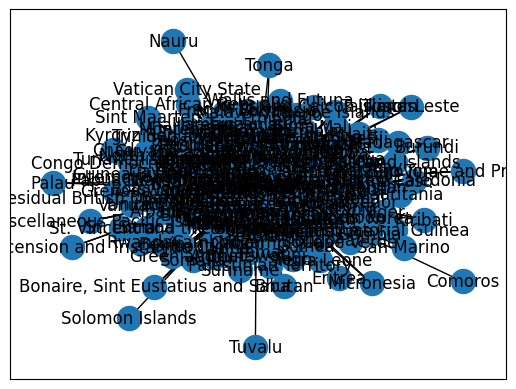

In [210]:
nx.draw_networkx(G.to_undirected())

In [216]:
# See: https://github.com/WestHealth/pyvis/issues/49#issuecomment-853087674
from IPython.core.display import display, HTML

net = Network(notebook=True,
            width="50%",
            height="400px",
            cdn_resources="remote",
            neighborhood_highlight=True,
            select_menu=True,
           )

net.toggle_hide_edges_on_drag(True)
net.barnes_hut()
net.repulsion(500)

# reuse plotly color palette
palette = px.colors.sequential.Plasma  # 7 colors
factor = len(deg)/len(palette)

net.from_nx(G2)

for node in net.nodes:
    degree = G2.degree(weight='2013-Q4')[node['label']]
    node['size'] = degree/50000
    node['color'] = palette[int(list(deg).index(node['label'])/factor)]

for edge in net.edges:
    # get value from main Network weight
    edge['value'] = G2.edges[edge['from'], edge['to']]['2013-Q4']

net.show("network.html")
display(HTML('network.html'))

network.html


# Evolution over time

Let's look at some shortest path over time

### Inspection of poor predictions

[Describe]

### Predictions

Now let's make predictions against unseen data

# Preparing for next steps

[What didn't we cover here?]